# **California Wildfire Prediction - Tabular Project**
## Mariah Noelle Cornelio

# ***MACHINE LEARNING***

### **GENERAL WORKFLOW OF THE NOTEBOOK -> 4 steps**
- Train models using a **21 day window**
    - Validate and evaluate validation set
    - Fine tune using a threshold that balances recall and F1 while prioritizing recall
        - Recall > F1 > Precision and ROC-AUC
    - Validate again 
    - Use on test set and evaluate
    - **Note:** Random Forest and XGBoost do not need windows -> 2D Input
- Do the same process for GRU, Bidirectional LSTM, Stacked LSTM, CNN+LSTM, Transformer, Random Forest, XGBoost
- Choose the best **time series** model
    - I just trained Random Forest and XGBoost to see if it would perform better (it did)
- Build fire forecast prototype tool

## **Problem Formulation**

**Import packages and CLEANED data from Feasibility notebook**

In [1]:
# Pre-processing and basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns # For easy correlation plot
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc

# Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention
from tensorflow.keras.layers import GRU, Dropout, Dense, Bidirectional, LSTM, Conv1D, MaxPooling1D
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [2]:
df = pd.read_csv("/Users/marielle/Desktop/firedf_cleaned.csv")
df.head(5)

,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,YEAR,TEMP_RANGE,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,SEASON_SIN,SEASON_COS,DAY_SIN,DAY_COS,FIRE_START_DAY
0,0.0,0.517857,0.409091,0.119360,0.0,0.666667,0.0,0.137577,0.0,1.0,0.017166,0.999853,0
1,0.0,0.375000,0.295455,0.155865,0.0,0.589744,0.0,0.179143,0.0,1.0,0.034328,0.999411,0
2,0.0,0.357143,0.318182,0.146842,0.0,0.538462,0.0,0.186149,0.0,1.0,0.051479,0.998674,0
3,0.0,0.464286,0.272727,0.119360,0.0,0.743590,0.0,0.174006,0.0,1.0,0.068615,0.997643,0
4,0.0,0.428571,0.363636,0.137408,0.0,0.589744,0.0,0.174940,0.0,1.0,0.085731,0.996318,0


**Remove unneed columns, for example:**
- **duplicated**
- **categorical features that were turned into one-hot -> done in pre-processing**
- **features that identify specific rows, like ID number -> done in pre-processing**
- **make sure your target is properly encoded also -> done in pre-processing**

In [3]:
# Check duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


In [4]:
# Check class distribution before creating windows for model
print(df['FIRE_START_DAY'].value_counts())

0    10017
1     4971
Name: FIRE_START_DAY, dtype: int64


## **Train ML Algorithm: LSTM (USING A 21 DAY WINDOW)**

**NOTE:** In the Project Rough Draft notebook, we already trained our rough LSTM model and found that from choicese of a 30-day, 21-day, and 14-day sliding window, the model was able to perform the best and identify fires within a 21 day timeframe. Metrics used to evaluate that was an ROC-AUC curve. 
- 30 DAY Validation ROC-AUC Score: 0.8288
- 21 DAY Validation ROC-AUC Score: 0.8273
- 14 DAY Validation ROC-AUC Score: 0.8262

**Extracting Features and Creating Sliding Window for LSTM**

In [5]:
# Features to use in our model
feature_cols = ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'TEMP_RANGE',
                'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED', 'YEAR', 'SEASON_SIN', 
                'SEASON_COS', 'DAY_SIN', 'DAY_COS']

target_col = 'FIRE_START_DAY'

# Extract the features
features = df[feature_cols].values
target = df[target_col].values

# Setting window size to 21 days before an event
window_size = 21

# Sliding window function
def create_sequences(features, labels, window=window_size):
    X, y = [], []
    for i in range(len(features) - window):
        X.append(features[i:i+window])
        y.append(labels[i+window])  # target on day 22
    return np.array(X), np.array(y)

# Create sequences from the dataset
X, y = create_sequences(features, target, window=window_size)

print(f"Total samples: {X.shape[0]}, Sequence length: {X.shape[1]}, Features per timestep: {X.shape[2]}")

Total samples: 14967, Sequence length: 21, Features per timestep: 12


**Split training sample into train, validation, and test sub-samples**

In [6]:
# Split into train (70%), validation (15%), test (15%)
num_samples = len(X)
train_end = int(0.7 * num_samples)
val_end = int(0.85 * num_samples)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print(f"Train samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Train samples: 10476
Validation samples: 2245
Test samples: 2246


**Build the LSTM Model (with Balanced Class Weights)**

In [47]:
# Define the input shape
timesteps = X_train.shape[1]  # 21 because we did the 21 day window
n_features = X_train.shape[2]  # Should be 12

# Calculate class weights to handle target feature imbalance
weights_lstm = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weight_lstm = dict(enumerate(weights_lstm))

# Build the actual LSTM model - 21 days over the 12 features
model_lstm = Sequential([LSTM(64, input_shape=(timesteps, n_features)), Dropout(0.3),
    Dense(32, activation='relu'), Dropout(0.2), Dense(1, activation='sigmoid')])

# Compile the model
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Recall(name='recall'), AUC(name='auc')])

model_lstm.summary()

/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,825 (85.25 KB)

 Trainable params: 21,825 (85.25 KB)

 Non-trainable params: 0 (0.00 B)

**Training Model with Class Weight**

From our project rough draft, we also found that early stopping improved our scores so we will do it here.

In [48]:
early_stop_lstm = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15,
    batch_size=64, class_weight=class_weight_lstm, verbose=2, callbacks=[early_stop_lstm])

Epoch 1/15
164/164 - 2s - 12ms/step - accuracy: 0.7430 - auc: 0.8122 - loss: 0.5316 - recall: 0.7718 - val_accuracy: 0.7390 - val_auc: 0.8245 - val_loss: 0.5440 - val_recall: 0.8221
Epoch 2/15
164/164 - 1s - 6ms/step - accuracy: 0.7580 - auc: 0.8319 - loss: 0.5048 - recall: 0.7868 - val_accuracy: 0.7488 - val_auc: 0.8249 - val_loss: 0.5387 - val_recall: 0.7642
Epoch 3/15
164/164 - 1s - 6ms/step - accuracy: 0.7622 - auc: 0.8353 - loss: 0.5005 - recall: 0.7902 - val_accuracy: 0.7430 - val_auc: 0.8317 - val_loss: 0.5517 - val_recall: 0.8387
Epoch 4/15
164/164 - 1s - 6ms/step - accuracy: 0.7595 - auc: 0.8403 - loss: 0.4922 - recall: 0.7884 - val_accuracy: 0.7073 - val_auc: 0.8327 - val_loss: 0.5685 - val_recall: 0.8759
Epoch 5/15
164/164 - 1s - 6ms/step - accuracy: 0.7595 - auc: 0.8409 - loss: 0.4914 - recall: 0.7927 - val_accuracy: 0.6944 - val_auc: 0.8315 - val_loss: 0.5896 - val_recall: 0.8821


## **Evaluate Performance on Validation Set**

For metrics I chose recall, precision, F1, and ROC-AUC curve, with recall being the most important. 
- **Recall**: Missing a fire could be catastrophic
- **Precision**: Helps control false alarms; important for trust in the system but less critical than recall
- **F1**: Balances precision and recall
- **ROC-AUC**: Shows model’s ability to discriminate fires from no-fires

From this, priority goes **Recall** > **F1** > **Precision**

In [49]:
# Predict probabilities for validation set
y_val_probs_lstm = model_lstm.predict(X_val).flatten()
y_val_preds_lstm = (y_val_probs_lstm >= 0.5).astype(int)  # Default threshold of 0.5

# Classification report (precision, recall, f1) and ROC-AUC curve
print("Classification Report (LSTM):")
print(classification_report(y_val, y_val_preds_lstm))

roc_auc_lstm = roc_auc_score(y_val, y_val_probs_lstm)
print(f"LSTM ROC-AUC Score: {roc_auc_lstm:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report (LSTM):
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1278
           1       0.69      0.76      0.72       967

    accuracy                           0.75      2245
   macro avg       0.75      0.75      0.75      2245
weighted avg       0.75      0.75      0.75      2245

LSTM ROC-AUC Score: 0.8253


## **Evaluate Performance: Tuning Thresholds to Balance and Optimize Recall/F1**

For our case, we don't necesarrily want to maximize recall. Having a maxed out recall means that our model catches almost all fires which is incredible for safety. However, there is a cost to it and that cost is having many false alarms. We do not want many false alarms because that can cause distrust in the system and potentially waste resources. So rather than maximizing recall, we want to balance it with F1 and precision while having acceptable scores.

In [50]:
thresholds = np.arange(0.40, 0.61, 0.01)  # Play around with thresholds to balance
best_thresh_lstm = 0.5
best_f1_lstm = 0
best_recall_lstm = 0
best_precision_lstm = 0

for t in thresholds:
    preds_lstm = (y_val_probs_lstm >= t).astype(int)
    recall = recall_score(y_val, preds_lstm)
    f1 = f1_score(y_val, preds_lstm)
    precision = precision_score(y_val, preds_lstm)

    if recall >= 0.80 and f1 > best_f1_lstm:
        best_f1_lstm = f1
        best_thresh_lstm = t
        best_recall_lstm = recall
        best_precision_lstm = precision

print(f"Chosen threshold (LSTM): {best_thresh_lstm:.2f}")
print(f"Recall (LSTM): {best_recall_lstm:.4f}")
print(f"F1-score (LSTM): {best_f1_lstm:.4f}")
print(f"Precision (LSTM): {best_precision_lstm:.4f}")

# Final predictions with chosen threshold
final_preds_lstm = (y_val_probs_lstm >= best_thresh_lstm).astype(int)

print("Classification Report (LSTM) with chosen threshold:")
print(classification_report(y_val, final_preds_lstm))
print(f"ROC-AUC Score (LSTM): {roc_auc_score(y_val, y_val_probs_lstm):.4f}")

Chosen threshold (LSTM): 0.41
Recall (LSTM): 0.8294
F1-score (LSTM): 0.7304
Precision (LSTM): 0.6526
Classification Report (LSTM) with chosen threshold:
              precision    recall  f1-score   support

           0       0.84      0.67      0.74      1278
           1       0.65      0.83      0.73       967

    accuracy                           0.74      2245
   macro avg       0.75      0.75      0.74      2245
weighted avg       0.76      0.74      0.74      2245

ROC-AUC Score (LSTM): 0.8253


**Evaluate Performance on Test Set for LSTM (After Tuning)**

In [51]:
# Predict probabilities on test set
y_test_probs_lstm = model_lstm.predict(X_test).flatten()
y_test_preds_lstm = (y_test_probs_lstm >= best_thresh_lstm).astype(int)

print("Test Set Classification Report (LSTM):")
print(classification_report(y_test, y_test_preds_lstm))
roc_auc_lstm_test = roc_auc_score(y_test, y_test_probs_lstm)
print(f"Test Set ROC-AUC Score (LSTM): {roc_auc_lstm_test:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Set Classification Report (LSTM):
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1436
           1       0.54      0.85      0.66       810

    accuracy                           0.69      2246
   macro avg       0.71      0.72      0.68      2246
weighted avg       0.75      0.69      0.69      2246

Test Set ROC-AUC Score (LSTM): 0.7919


## **Model #2: GRU**

**Apply the same steps as we did with LSTM to GRU**

In [52]:
# Windowing and splitting dataset is the same!

# Define input shape - same
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# Calculate weights - same
weights_gru = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weight_gru = dict(enumerate(weights_gru))

# Build GRU model
model_gru = Sequential([GRU(64, input_shape=(timesteps, n_features)), Dropout(0.3),
    Dense(32, activation='relu'), Dropout(0.2), Dense(1, activation='sigmoid')])

# Compile model - same
model_gru.compile(loss='binary_crossentropy', optimizer='adam',
    metrics=['accuracy', Recall(name='recall'), AUC(name='auc')])

model_gru.summary()

/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,089 (66.75 KB)

 Trainable params: 17,089 (66.75 KB)

 Non-trainable params: 0 (0.00 B)

**Train GRU Model**

In [53]:
# Early stopping - same
early_stop_gru = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training model - same
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_val, y_val),
    epochs=15, batch_size=64, class_weight=class_weight_gru, verbose=2, callbacks=[early_stop_gru])

Epoch 1/15
164/164 - 2s - 13ms/step - accuracy: 0.7429 - auc: 0.8172 - loss: 0.5255 - recall: 0.7905 - val_accuracy: 0.7519 - val_auc: 0.8253 - val_loss: 0.5228 - val_recall: 0.7983
Epoch 2/15
164/164 - 1s - 6ms/step - accuracy: 0.7588 - auc: 0.8345 - loss: 0.5003 - recall: 0.7984 - val_accuracy: 0.7421 - val_auc: 0.8284 - val_loss: 0.5499 - val_recall: 0.8480
Epoch 3/15
164/164 - 1s - 6ms/step - accuracy: 0.7578 - auc: 0.8385 - loss: 0.4935 - recall: 0.8049 - val_accuracy: 0.7612 - val_auc: 0.8290 - val_loss: 0.5185 - val_recall: 0.7684
Epoch 4/15
164/164 - 1s - 6ms/step - accuracy: 0.7627 - auc: 0.8423 - loss: 0.4887 - recall: 0.7968 - val_accuracy: 0.7416 - val_auc: 0.8273 - val_loss: 0.5586 - val_recall: 0.8376
Epoch 5/15
164/164 - 1s - 6ms/step - accuracy: 0.7603 - auc: 0.8406 - loss: 0.4912 - recall: 0.8006 - val_accuracy: 0.7434 - val_auc: 0.8282 - val_loss: 0.5399 - val_recall: 0.8356
Epoch 6/15
164/164 - 1s - 6ms/step - accuracy: 0.7603 - auc: 0.8430 - loss: 0.4872 - recall: 0

**Pre-Tuning Evaluation Validation Set**

In [54]:
# Predict validation probabilities
y_val_probs_gru = model_gru.predict(X_val).flatten()

# Default threshold evaluation
y_val_preds_gru = (y_val_probs_gru >= 0.5).astype(int)
print("Validation set results with default threshold 0.5 (GRU):")
print(classification_report(y_val, y_val_preds_gru))
print(f"ROC-AUC (GRU): {roc_auc_score(y_val, y_val_probs_gru):.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation set results with default threshold 0.5 (GRU):
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1278
           1       0.70      0.77      0.73       967

    accuracy                           0.76      2245
   macro avg       0.76      0.76      0.76      2245
weighted avg       0.77      0.76      0.76      2245

ROC-AUC (GRU): 0.8289


**GRU Threshold Tuning**

In [55]:
thresholds = np.arange(0.40, 0.61, 0.01)
best_thresh_gru = 0.5
best_f1_gru = 0
best_recall_gru = 0
best_precision_gru = 0

for t in thresholds:
    preds_gru = (y_val_probs_gru >= t).astype(int)
    recall = recall_score(y_val, preds_gru)
    f1 = f1_score(y_val, preds_gru)
    precision = precision_score(y_val, preds_gru)

    if recall >= 0.80 and f1 > best_f1_gru:
        best_f1_gru = f1
        best_thresh_gru = t
        best_recall_gru = recall
        best_precision_gru = precision

print(f"Chosen threshold (GRU): {best_thresh_gru:.2f}")
print(f"Recall (GRU): {best_recall_gru:.4f}")
print(f"F1-score (GRU): {best_f1_gru:.4f}")
print(f"Precision (GRU): {best_precision_gru:.4f}")

final_preds_gru = (y_val_probs_gru >= best_thresh_gru).astype(int)

print("Validation set results after threshold tuning (GRU):")
print(classification_report(y_val, final_preds_gru))
print(f"ROC-AUC (GRU): {roc_auc_score(y_val, y_val_probs_gru):.4f}")

Chosen threshold (GRU): 0.43
Recall (GRU): 0.8159
F1-score (GRU): 0.7391
Precision (GRU): 0.6755
Validation set results after threshold tuning (GRU):
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1278
           1       0.68      0.82      0.74       967

    accuracy                           0.75      2245
   macro avg       0.76      0.76      0.75      2245
weighted avg       0.77      0.75      0.75      2245

ROC-AUC (GRU): 0.8289


**GRU Test Set Evaluation with Tuning**

In [56]:
y_test_probs_gru = model_gru.predict(X_test).flatten()
y_test_preds_gru = (y_test_probs_gru >= best_thresh_gru).astype(int)

y_test_probs_gru = model_gru.predict(X_test).flatten()
y_test_preds_gru = (y_test_probs_gru >= best_thresh_gru).astype(int)

print("Test set results (GRU):")
print(classification_report(y_test, y_test_preds_gru))
print(f"ROC-AUC (GRU): {roc_auc_score(y_test, y_test_probs_gru):.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test set results (GRU):
              precision    recall  f1-score   support

           0       0.88      0.62      0.73      1436
           1       0.56      0.85      0.67       810

    accuracy                           0.71      2246
   macro avg       0.72      0.74      0.70      2246
weighted avg       0.76      0.71      0.71      2246

ROC-AUC (GRU): 0.8001


## **Model #3: BiDirectional LSTM**

**Building the Bidirectional LSTM Model**

In [57]:
timesteps = X_train.shape[1]
n_features = X_train.shape[2] 

weights_bi_lstm = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weight_bi_lstm = dict(enumerate(weights_bi_lstm))

model_bi_lstm = Sequential([Bidirectional(LSTM(64), input_shape=(timesteps, n_features)),
    Dropout(0.3), Dense(32, activation='relu'), Dropout(0.2), Dense(1, activation='sigmoid')])

model_bi_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Recall(name='recall'), AUC(name='auc')])

model_bi_lstm.summary()

/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        39,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,585 (170.25 KB)

 Trainable params: 43,585 (170.25 KB)

 Non-trainable params: 0 (0.00 B)

**Train Bidirectional LSTM Model with Early Stopping**

In [58]:
early_stop_bi_lstm = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_bi_lstm = model_bi_lstm.fit(X_train, y_train, validation_data=(X_val, y_val),
    epochs=15, batch_size=64, class_weight=class_weight_bi_lstm, verbose=2, callbacks=[early_stop_bi_lstm])

Epoch 1/15
164/164 - 3s - 18ms/step - accuracy: 0.7522 - auc: 0.8198 - loss: 0.5218 - recall: 0.7699 - val_accuracy: 0.7461 - val_auc: 0.8266 - val_loss: 0.5378 - val_recall: 0.8025
Epoch 2/15
164/164 - 2s - 12ms/step - accuracy: 0.7556 - auc: 0.8342 - loss: 0.5023 - recall: 0.7768 - val_accuracy: 0.7243 - val_auc: 0.8265 - val_loss: 0.5583 - val_recall: 0.8459
Epoch 3/15
164/164 - 2s - 12ms/step - accuracy: 0.7560 - auc: 0.8372 - loss: 0.4977 - recall: 0.7915 - val_accuracy: 0.7421 - val_auc: 0.8307 - val_loss: 0.5624 - val_recall: 0.8304
Epoch 4/15
164/164 - 2s - 12ms/step - accuracy: 0.7620 - auc: 0.8388 - loss: 0.4942 - recall: 0.7912 - val_accuracy: 0.7385 - val_auc: 0.8304 - val_loss: 0.5547 - val_recall: 0.8521


**Evaluate on validation and test sets (default threshold 0.5)**

In [59]:
# Validation set predictions
y_val_probs_bi_lstm = model_bi_lstm.predict(X_val).flatten()
y_val_preds_bi_lstm = (y_val_probs_bi_lstm >= 0.5).astype(int)

y_test_probs_bi_lstm = model_bi_lstm.predict(X_test).flatten()
y_test_preds_bi_lstm = (y_test_probs_bi_lstm >= 0.5).astype(int)

print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_preds_bi_lstm))
print(f"Validation ROC-AUC Score: {roc_auc_score(y_val, y_val_probs_bi_lstm):.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.70      0.76      1278
           1       0.67      0.80      0.73       967

    accuracy                           0.75      2245
   macro avg       0.75      0.75      0.75      2245
weighted avg       0.76      0.75      0.75      2245

Validation ROC-AUC Score: 0.8268


**Evaluate on validation and test sets (after tuning) on Bidirectional LSTM model**

In [60]:
thresholds = np.arange(0.40, 0.61, 0.01)
best_thresh_bi_lstm = 0.5
best_f1_bi_lstm = 0
best_recall_bi_lstm = 0
best_precision_bi_lstm = 0

for t in thresholds:
    preds_bi_lstm = (y_val_probs_bi_lstm >= t).astype(int)
    recall = recall_score(y_val, preds_bi_lstm)
    f1 = f1_score(y_val, preds_bi_lstm)
    precision = precision_score(y_val, preds_bi_lstm)

    if recall >= 0.80 and f1 > best_f1_bi_lstm:
        best_f1_bi_lstm = f1
        best_thresh_bi_lstm = t
        best_recall_bi_lstm = recall
        best_precision_bi_lstm = precision

print(f"Chosen threshold (Bi-LSTM): {best_thresh_bi_lstm:.2f}")
print(f"Recall (Bi-LSTM): {best_recall_bi_lstm:.4f}")
print(f"F1-score (Bi-LSTM): {best_f1_bi_lstm:.4f}")
print(f"Precision (Bi-LSTM): {best_precision_bi_lstm:.4f}")

final_preds_val_bi_lstm = (y_val_probs_bi_lstm >= best_thresh_bi_lstm).astype(int)
print("Validation Set Classification Report (Bi-LSTM):")
print(classification_report(y_val, final_preds_val_bi_lstm))

# Apply chosen threshold on test set
final_preds_test_bi_lstm = (y_test_probs_bi_lstm >= best_thresh_bi_lstm).astype(int)
print("Test Set Classification Report (Bi-LSTM):")
print(classification_report(y_test, final_preds_test_bi_lstm))
print(f"Test ROC-AUC Score (Bi-LSTM): {roc_auc_score(y_test, y_test_probs_bi_lstm):.4f}")

Chosen threshold (Bi-LSTM): 0.47
Recall (Bi-LSTM): 0.8211
F1-score (Bi-LSTM): 0.7328
Precision (Bi-LSTM): 0.6617
Validation Set Classification Report (Bi-LSTM):
              precision    recall  f1-score   support

           0       0.83      0.68      0.75      1278
           1       0.66      0.82      0.73       967

    accuracy                           0.74      2245
   macro avg       0.75      0.75      0.74      2245
weighted avg       0.76      0.74      0.74      2245

Test Set Classification Report (Bi-LSTM):
              precision    recall  f1-score   support

           0       0.88      0.63      0.73      1436
           1       0.56      0.85      0.68       810

    accuracy                           0.71      2246
   macro avg       0.72      0.74      0.70      2246
weighted avg       0.77      0.71      0.71      2246

Test ROC-AUC Score (Bi-LSTM): 0.7937


## **Model #4: Stacked LSTM**

**Building the Stacked LSTM Model**

In [61]:
# Define input shape
timesteps = X_train.shape[1]
n_features = X_train.shape[2] 

# Compute class weights
weights_stacked_lstm = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weight_stacked_lstm = dict(enumerate(weights_stacked_lstm))

# Build Stacked LSTM Model
model_stacked_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(timesteps, n_features)),  # return sequences for stacking
    Dropout(0.3), LSTM(32),  # final LSTM layer
    Dropout(0.2), Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])

# Compile the model
model_stacked_lstm.compile(loss='binary_crossentropy', optimizer='adam',
    metrics=['accuracy', Recall(name='recall'), AUC(name='auc')])

model_stacked_lstm.summary()

/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 21, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

**Training Stacked LSTM Model**

In [62]:
early_stop_stacked_lstm = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_stacked_lstm = model_stacked_lstm.fit(X_train, y_train, validation_data=(X_val, y_val),
    epochs=15, batch_size=64, class_weight=class_weight_stacked_lstm,
    verbose=2, callbacks=[early_stop_stacked_lstm])

Epoch 1/15
164/164 - 4s - 22ms/step - accuracy: 0.7442 - auc: 0.8164 - loss: 0.5241 - recall: 0.7774 - val_accuracy: 0.7296 - val_auc: 0.8259 - val_loss: 0.5527 - val_recall: 0.8397
Epoch 2/15
164/164 - 2s - 11ms/step - accuracy: 0.7556 - auc: 0.8328 - loss: 0.5050 - recall: 0.7793 - val_accuracy: 0.7198 - val_auc: 0.8281 - val_loss: 0.5826 - val_recall: 0.8521
Epoch 3/15
164/164 - 2s - 10ms/step - accuracy: 0.7560 - auc: 0.8386 - loss: 0.4956 - recall: 0.7884 - val_accuracy: 0.7310 - val_auc: 0.8250 - val_loss: 0.5531 - val_recall: 0.8273
Epoch 4/15
164/164 - 2s - 10ms/step - accuracy: 0.7574 - auc: 0.8370 - loss: 0.4974 - recall: 0.7959 - val_accuracy: 0.7385 - val_auc: 0.8310 - val_loss: 0.5694 - val_recall: 0.8407


**Evaluate on validation and test sets (default threshold = 0.5)**

In [63]:
# Evaluate before threshold tuning on validation set
y_val_probs_stacked_lstm = model_stacked_lstm.predict(X_val).flatten()
y_val_preds_stacked_lstm = (y_val_probs_stacked_lstm >= 0.5).astype(int)  # default threshold 0.5

y_test_probs_stacked_lstm = model_stacked_lstm.predict(X_test).flatten()
y_test_preds_stacked_lstm = (y_test_probs_stacked_lstm >= 0.5).astype(int) 

print("Validation Classification Report (Stacked LSTM, Threshold=0.5):")
print(classification_report(y_val, y_val_preds_stacked_lstm))
print(f"Validation ROC-AUC Score (Stacked LSTM): {roc_auc_score(y_val, y_val_probs_stacked_lstm):.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Classification Report (Stacked LSTM, Threshold=0.5):
              precision    recall  f1-score   support

           0       0.84      0.65      0.73      1278
           1       0.64      0.84      0.73       967

    accuracy                           0.73      2245
   macro avg       0.74      0.74      0.73      2245
weighted avg       0.76      0.73      0.73      2245

Validation ROC-AUC Score (Stacked LSTM): 0.8266


**Evaluate on validation and test sets (after tuning) on Stacked LSTM model**

In [64]:
thresholds = np.arange(0.40, 0.61, 0.01)
best_thresh_stacked_lstm = 0.5
best_f1_stacked_lstm = 0
best_recall_stacked_lstm = 0
best_precision_stacked_lstm = 0

for t in thresholds:
    preds_stacked_lstm = (y_val_probs_stacked_lstm >= t).astype(int)
    recall = recall_score(y_val, preds_stacked_lstm)
    f1 = f1_score(y_val, preds_stacked_lstm)
    precision = precision_score(y_val, preds_stacked_lstm)

    if recall >= 0.80 and f1 > best_f1_stacked_lstm:
        best_f1_stacked_lstm = f1
        best_thresh_stacked_lstm = t
        best_recall_stacked_lstm = recall
        best_precision_stacked_lstm = precision

print(f"Chosen threshold (Stacked LSTM): {best_thresh_stacked_lstm:.2f}")
print(f"Recall (Stacked LSTM): {best_recall_stacked_lstm:.4f}")
print(f"F1-score (Stacked LSTM): {best_f1_stacked_lstm:.4f}")
print(f"Precision (Stacked LSTM): {best_precision_stacked_lstm:.4f}")

# Validation set with tuned threshold
final_preds_val_stacked_lstm = (y_val_probs_stacked_lstm >= best_thresh_stacked_lstm).astype(int)

print("Validation Classification Report (Stacked LSTM, After Tuning):")
print(classification_report(y_val, final_preds_val_stacked_lstm))
print(f"Validation ROC-AUC Score (Stacked LSTM): {roc_auc_score(y_val, y_val_probs_stacked_lstm):.4f}")

# Test set with tuned threshold
final_preds_test_stacked_lstm = (y_test_probs_stacked_lstm >= best_thresh_stacked_lstm).astype(int)
# Predict on test set with tuned threshold

print("Test Set Classification Report (Stacked LSTM, After Tuning):")
print(classification_report(y_test, final_preds_test_stacked_lstm))
print(f"Test Set ROC-AUC Score (Stacked LSTM): {roc_auc_score(y_test, y_test_probs_stacked_lstm):.4f}")

Chosen threshold (Stacked LSTM): 0.58
Recall (Stacked LSTM): 0.8097
F1-score (Stacked LSTM): 0.7362
Precision (Stacked LSTM): 0.6750
Validation Classification Report (Stacked LSTM, After Tuning):
              precision    recall  f1-score   support

           0       0.83      0.71      0.76      1278
           1       0.68      0.81      0.74       967

    accuracy                           0.75      2245
   macro avg       0.75      0.76      0.75      2245
weighted avg       0.76      0.75      0.75      2245

Validation ROC-AUC Score (Stacked LSTM): 0.8266
Test Set Classification Report (Stacked LSTM, After Tuning):
              precision    recall  f1-score   support

           0       0.88      0.63      0.73      1436
           1       0.56      0.84      0.67       810

    accuracy                           0.70      2246
   macro avg       0.72      0.73      0.70      2246
weighted avg       0.76      0.70      0.71      2246

Test Set ROC-AUC Score (Stacked LSTM): 0.

## **Model #5: CNN+LSTM**

**Building the CNN+LSTM Model**

In [7]:
# Input shapes
timesteps = X_train.shape[1]  # 21
n_features = X_train.shape[2]  # 12

# Compute class weights
weights_cnn_lstm = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_cnn_lstm = dict(enumerate(weights_cnn_lstm))

# Build CNN + LSTM model
model_cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)),
    MaxPooling1D(pool_size=2), LSTM(64), Dropout(0.3), Dense(32, activation='relu'),
    Dropout(0.2), Dense(1, activation='sigmoid')])

# Compile the model
model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam',
    metrics=['accuracy', Recall(name='recall'), AUC(name='auc')])

model_cnn_lstm.summary()

/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 19, 64)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,505 (146.50 KB)

 Trainable params: 37,505 (146.50 KB)

 Non-trainable params: 0 (0.00 B)

**Training CNN+LSTM Model**

In [8]:
early_stop_cnn_lstm = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, validation_data=(X_val, y_val),
    epochs=15, batch_size=64, class_weight=class_weight_cnn_lstm, verbose=2, callbacks=[early_stop_cnn_lstm])

Epoch 1/15
164/164 - 2s - 11ms/step - accuracy: 0.7458 - auc: 0.8159 - loss: 0.5274 - recall: 0.7865 - val_accuracy: 0.7265 - val_auc: 0.8267 - val_loss: 0.5609 - val_recall: 0.8625
Epoch 2/15
164/164 - 1s - 5ms/step - accuracy: 0.7586 - auc: 0.8303 - loss: 0.5077 - recall: 0.7749 - val_accuracy: 0.7457 - val_auc: 0.8286 - val_loss: 0.5333 - val_recall: 0.8139
Epoch 3/15
164/164 - 1s - 5ms/step - accuracy: 0.7604 - auc: 0.8332 - loss: 0.5029 - recall: 0.7827 - val_accuracy: 0.7457 - val_auc: 0.8300 - val_loss: 0.5333 - val_recall: 0.7942
Epoch 4/15
164/164 - 1s - 4ms/step - accuracy: 0.7599 - auc: 0.8361 - loss: 0.4991 - recall: 0.7840 - val_accuracy: 0.7287 - val_auc: 0.8301 - val_loss: 0.5496 - val_recall: 0.8428
Epoch 5/15
164/164 - 1s - 4ms/step - accuracy: 0.7579 - auc: 0.8375 - loss: 0.4971 - recall: 0.7824 - val_accuracy: 0.7216 - val_auc: 0.8304 - val_loss: 0.5795 - val_recall: 0.8676
Epoch 6/15
164/164 - 1s - 5ms/step - accuracy: 0.7610 - auc: 0.8387 - loss: 0.4952 - recall: 0

**Evaluate on validation set (default threshold = 0.5)**

In [9]:
# Validation
y_val_probs_cnn_lstm = model_cnn_lstm.predict(X_val).flatten()
y_val_preds_cnn_lstm = (y_val_probs_cnn_lstm >= 0.5).astype(int)

y_test_probs_cnn_lstm = model_cnn_lstm.predict(X_test).flatten()
y_test_preds_cnn_lstm = (y_test_probs_cnn_lstm >= 0.5).astype(int)

print("Validation Classification Report (CNN + LSTM, Threshold=0.5):")
print(classification_report(y_val, y_val_preds_cnn_lstm))
print(f"Validation ROC-AUC Score (CNN + LSTM): {roc_auc_score(y_val, y_val_probs_cnn_lstm):.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
Validation Classification Report (CNN + LSTM, Threshold=0.5):
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1278
           1       0.67      0.79      0.73       967

    accuracy                           0.75      2245
   macro avg       0.75      0.75      0.74      2245
weighted avg       0.76      0.75      0.75      2245

Validation ROC-AUC Score (CNN + LSTM): 0.8300


**Evaluate on validation and test sets (after tuning) on CNN+LSTM model**

In [10]:
thresholds = np.arange(0.40, 0.61, 0.01)
best_thresh_cnn_lstm = 0.5
best_f1_cnn_lstm = 0
best_recall_cnn_lstm = 0
best_precision_cnn_lstm = 0

for t in thresholds:
    preds_cnn_lstm = (y_val_probs_cnn_lstm >= t).astype(int)
    recall = recall_score(y_val, preds_cnn_lstm)
    f1 = f1_score(y_val, preds_cnn_lstm)
    precision = precision_score(y_val, preds_cnn_lstm)

    if recall >= 0.80 and f1 > best_f1_cnn_lstm:
        best_f1_cnn_lstm = f1
        best_thresh_cnn_lstm = t
        best_recall_cnn_lstm = recall
        best_precision_cnn_lstm = precision

print(f"\nBest Threshold (CNN + LSTM): {best_thresh_cnn_lstm:.2f}")
print(f"Recall: {best_recall_cnn_lstm:.4f}, F1-score: {best_f1_cnn_lstm:.4f}, Precision: {best_precision_cnn_lstm:.4f}")

# Validation set with best threshold
final_val_preds_cnn_lstm = (y_val_probs_cnn_lstm >= best_thresh_cnn_lstm).astype(int)

print("Validation Set Classification Report (CNN + LSTM, Tuned Threshold):")
print(classification_report(y_val, final_val_preds_cnn_lstm))
print(f"Validation Set ROC-AUC Score (CNN + LSTM): {roc_auc_score(y_val, y_val_probs_cnn_lstm):.4f}")

# Test set with best threshold
final_test_preds_cnn_lstm = (y_test_probs_cnn_lstm >= best_thresh_cnn_lstm).astype(int)

print("Test Set Classification Report (CNN + LSTM, Tuned Threshold):")
print(classification_report(y_test, final_test_preds_cnn_lstm))
print(f"Test Set ROC-AUC Score (CNN + LSTM): {roc_auc_score(y_test, y_test_probs_cnn_lstm):.4f}")


Best Threshold (CNN + LSTM): 0.47
Recall: 0.8211, F1-score: 0.7345, Precision: 0.6644
Validation Set Classification Report (CNN + LSTM, Tuned Threshold):
              precision    recall  f1-score   support

           0       0.84      0.69      0.75      1278
           1       0.66      0.82      0.73       967

    accuracy                           0.74      2245
   macro avg       0.75      0.75      0.74      2245
weighted avg       0.76      0.74      0.75      2245

Validation Set ROC-AUC Score (CNN + LSTM): 0.8300
Test Set Classification Report (CNN + LSTM, Tuned Threshold):
              precision    recall  f1-score   support

           0       0.88      0.63      0.74      1436
           1       0.57      0.85      0.68       810

    accuracy                           0.71      2246
   macro avg       0.72      0.74      0.71      2246
weighted avg       0.77      0.71      0.72      2246

Test Set ROC-AUC Score (CNN + LSTM): 0.7986


## **Model #6: Transformer**

**Building the Transformer Model**

In [70]:
class PositionalEncoding(Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'pos_encoding': self.pos_encoding.numpy(),
        })
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [71]:
class TransformerEncoder(Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoder, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, x, training=False):
        attn_output = self.mha(x, x, x, training=training)  # Pass training here
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [72]:
timesteps = X_train.shape[1]  # 21
n_features = X_train.shape[2]  # 12

d_model = 64     # embedding dimension
num_heads = 4    # attention heads
dff = 128        # feed-forward network units
dropout_rate = 0.1

inputs = Input(shape=(timesteps, n_features))
x = Dense(d_model)(inputs)  # Linear projection to d_model dimension
x = PositionalEncoding(timesteps, d_model)(x)

# Stack Transformer encoder layers (try 2)
for _ in range(2):
    x = TransformerEncoder(d_model, num_heads, dff, dropout_rate)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_transformer = Model(inputs=inputs, outputs=outputs)

model_transformer.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])

model_transformer.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 21, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 21, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_1           │ (None, 21, 64)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_2           │ (None, 21, 64)         │        83,200 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, 21, 64)         │        83,200 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,345 (661.50 KB)

 Trainable params: 169,345 (661.50 KB)

 Non-trainable params: 0 (0.00 B)

**Training the Transformer Model**

In [73]:
# Compute class weights (if not done already)
weights_transformer = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weight_transformer = dict(enumerate(weights_transformer))

# Early stopping callback
early_stop_transformer = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the Transformer model
history_transformer = model_transformer.fit(X_train, y_train,
    validation_data=(X_val, y_val), epochs=15, batch_size=64, class_weight=class_weight_transformer,
    verbose=2, callbacks=[early_stop_transformer])

Epoch 1/15
164/164 - 8s - 48ms/step - accuracy: 0.7299 - auc: 0.8002 - loss: 0.5472 - recall: 0.7595 - val_accuracy: 0.7443 - val_auc: 0.8219 - val_loss: 0.5504 - val_recall: 0.8201
Epoch 2/15
164/164 - 6s - 34ms/step - accuracy: 0.7527 - auc: 0.8186 - loss: 0.5237 - recall: 0.7774 - val_accuracy: 0.7599 - val_auc: 0.8238 - val_loss: 0.5178 - val_recall: 0.7528
Epoch 3/15
164/164 - 5s - 32ms/step - accuracy: 0.7501 - auc: 0.8231 - loss: 0.5188 - recall: 0.7818 - val_accuracy: 0.7372 - val_auc: 0.8249 - val_loss: 0.5456 - val_recall: 0.8459
Epoch 4/15
164/164 - 5s - 32ms/step - accuracy: 0.7571 - auc: 0.8275 - loss: 0.5123 - recall: 0.7840 - val_accuracy: 0.7461 - val_auc: 0.8269 - val_loss: 0.5424 - val_recall: 0.8180
Epoch 5/15
164/164 - 5s - 33ms/step - accuracy: 0.7528 - auc: 0.8363 - loss: 0.4996 - recall: 0.7937 - val_accuracy: 0.6958 - val_auc: 0.8286 - val_loss: 0.5850 - val_recall: 0.8956


**Evaluate on validation set (default threshold) for Transformer**

In [74]:
# Predict probabilities on validation set
y_val_probs_transformer = model_transformer.predict(X_val).flatten()
y_val_preds_transformer = (y_val_probs_transformer >= 0.5).astype(int)

y_test_probs_transformer = model_transformer.predict(X_test).flatten()
y_test_preds_transformer = (y_test_probs_transformer >= 0.5).astype(int)


print("Validation Set Classification Report (Transformer, Threshold=0.5):")
print(classification_report(y_val, y_val_preds_transformer))
print(f"Validation ROC-AUC Score: {roc_auc_score(y_val, y_val_probs_transformer):.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation Set Classification Report (Transformer, Threshold=0.5):
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1278
           1       0.71      0.75      0.73       967

    accuracy                           0.76      2245
   macro avg       0.76      0.76      0.76      2245
weighted avg       0.76      0.76      0.76      2245

Validation ROC-AUC Score: 0.8242


**Evaluate on validation and test sets (after tuning) on Transformer model**

In [75]:
thresholds = np.arange(0.40, 0.61, 0.01)
best_thresh_transformer = 0.5
best_f1_transformer = 0
best_recall_transformer = 0
best_precision_transformer = 0

for t in thresholds:
    preds_transformer = (y_val_probs_transformer >= t).astype(int)
    recall = recall_score(y_val, preds_transformer)
    f1 = f1_score(y_val, preds_transformer)
    precision = precision_score(y_val, preds_transformer)

    if recall >= 0.80 and f1 > best_f1_transformer:
        best_f1_transformer = f1
        best_thresh_transformer = t
        best_recall_transformer = recall
        best_precision_transformer = precision

print(f"Chosen threshold (Transformer): {best_thresh_transformer:.2f}")
print(f"Recall: {best_recall_transformer:.4f}")
print(f"F1-score: {best_f1_transformer:.4f}")
print(f"Precision: {best_precision_transformer:.4f}")

# Validation set with tuned threshold
final_preds_val_transformer = (y_val_probs_transformer >= best_thresh_transformer).astype(int)

print("Validation Set Classification Report (Transformer, Tuned Threshold):")
print(classification_report(y_val, final_preds_val_transformer))
print(f"Validation ROC-AUC Score: {roc_auc_score(y_val, y_val_probs_transformer):.4f}")

# Test set with tuned threshold
final_preds_test_transformer = (y_test_probs_transformer >= best_thresh_transformer).astype(int)

print("Test Set Classification Report (Transformer, Tuned Threshold):")
print(classification_report(y_test, final_preds_test_transformer))
print(f"Test ROC-AUC Score: {roc_auc_score(y_test, y_test_probs_transformer):.4f}")

Chosen threshold (Transformer): 0.41
Recall: 0.8004
F1-score: 0.7323
Precision: 0.6748
Validation Set Classification Report (Transformer, Tuned Threshold):
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1278
           1       0.67      0.80      0.73       967

    accuracy                           0.75      2245
   macro avg       0.75      0.75      0.75      2245
weighted avg       0.76      0.75      0.75      2245

Validation ROC-AUC Score: 0.8242
Test Set Classification Report (Transformer, Tuned Threshold):
              precision    recall  f1-score   support

           0       0.87      0.65      0.74      1436
           1       0.57      0.83      0.68       810

    accuracy                           0.71      2246
   macro avg       0.72      0.74      0.71      2246
weighted avg       0.76      0.71      0.72      2246

Test ROC-AUC Score: 0.7947


## **Model #7: Random Forest**

In [35]:
# Features and targetfor Rnadom Forest
feature_cols = ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'TEMP_RANGE',
                'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED', 'YEAR', 'SEASON_SIN', 
                'SEASON_COS', 'DAY_SIN', 'DAY_COS']
target_col = 'FIRE_START_DAY'

X = df[feature_cols]
y = df[target_col]

# Split the data (train 70%, val 15%, test 15%) with stratify to keep class balance
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val)

# Initialize and train Random Forest with balanced class weight
model_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_rf.fit(X_train, y_train)

# Predict probabilities on validation set
y_val_probs_rf = model_rf.predict_proba(X_val)[:, 1]

# Threshold tuning to balance recall >= 0.80 and maximize F1
thresholds = np.arange(0.40, 0.61, 0.01)
best_thresh_rf = 0.5
best_f1_rf = 0
best_recall_rf = 0
best_precision_rf = 0

for t in thresholds:
    preds = (y_val_probs_rf >= t).astype(int)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    precision = precision_score(y_val, preds)
    
    if f1 > best_f1_rf:
        best_f1_rf = f1
        best_thresh_rf = t
        best_recall_rf = recall
        best_precision_rf = precision

print(f"Chosen threshold (Random Forest): {best_thresh_rf:.2f}")
print(f"Recall: {best_recall_rf:.4f}")
print(f"F1-score: {best_f1_rf:.4f}")
print(f"Precision: {best_precision_rf:.4f}")

# Final predictions on validation set with best threshold
final_val_preds_rf = (y_val_probs_rf >= best_thresh_rf).astype(int)
print("Validation Set Classification Report (Random Forest):")
print(classification_report(y_val, final_val_preds_rf))
print(f"Validation ROC-AUC Score: {roc_auc_score(y_val, y_val_probs_rf):.4f}")

# Predict on test set and evaluate
y_test_probs_rf = model_rf.predict_proba(X_test)[:, 1]
y_test_preds_rf = (y_test_probs_rf >= best_thresh_rf).astype(int)

print("Test Set Classification Report (Random Forest):")
print(classification_report(y_test, y_test_preds_rf))
print(f"Test Set ROC-AUC Score: {roc_auc_score(y_test, y_test_probs_rf):.4f}")

Chosen threshold (Random Forest): 0.40
Recall: 0.6909
F1-score: 0.6602
Precision: 0.6322
Validation Set Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1499
           1       0.63      0.69      0.66       744

    accuracy                           0.76      2243
   macro avg       0.74      0.75      0.74      2243
weighted avg       0.77      0.76      0.77      2243

Validation ROC-AUC Score: 0.8377
Test Set Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1503
           1       0.67      0.71      0.69       746

    accuracy                           0.79      2249
   macro avg       0.76      0.77      0.76      2249
weighted avg       0.79      0.79      0.79      2249

Test Set ROC-AUC Score: 0.8427


## **Model #8: XGBoost**

In [36]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Play around with the params!!2212111#231243r
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'scale_pos_weight': (len(y_train) - sum(y_train)) / sum(y_train),  # handle class imbalance
    'eta': 0.1,
    'max_depth': 5,
    'seed': 42,}

evallist = [(dtrain, 'train'), (dval, 'eval')]

# Train model with early stopping
model_xgb = xgb.train(params, dtrain, num_boost_round=1000, evals=evallist,
                      early_stopping_rounds=10, verbose_eval=10)

# Predict probabilities on validation set
y_val_probs_xgb = model_xgb.predict(dval)
y_val_preds_xgb = (y_val_probs_xgb >= 0.5).astype(int)

print("Validation Set Classification Report (XGBoost, Threshold=0.5):")
print(classification_report(y_val, y_val_preds_xgb))
print(f"Validation ROC-AUC Score: {roc_auc_score(y_val, y_val_probs_xgb):.4f}")

# Threshold tuning
thresholds = np.arange(0.40, 0.61, 0.01)
best_thresh_xgb = 0.5
best_f1_xgb = 0
best_recall_xgb = 0
best_precision_xgb = 0

for t in thresholds:
    preds = (y_val_probs_xgb >= t).astype(int)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    precision = precision_score(y_val, preds)

    if f1 > best_f1_xgb:  # relax recall constraint here
        best_f1_xgb = f1
        best_thresh_xgb = t
        best_recall_xgb = recall
        best_precision_xgb = precision

print(f"Chosen threshold (XGBoost): {best_thresh_xgb:.2f}")
print(f"Recall: {best_recall_xgb:.4f}")
print(f"F1-score: {best_f1_xgb:.4f}")
print(f"Precision: {best_precision_xgb:.4f}")

# Predict on test set with tuned threshold
y_test_probs_xgb = model_xgb.predict(dtest)
y_test_preds_xgb = (y_test_probs_xgb >= best_thresh_xgb).astype(int)

print("Test Set Classification Report (XGBoost):")
print(classification_report(y_test, y_test_preds_xgb))
print(f"Test Set ROC-AUC Score: {roc_auc_score(y_test, y_test_probs_xgb):.4f}")

[0]	train-logloss:0.65629	eval-logloss:0.65868
[10]	train-logloss:0.49740	eval-logloss:0.51379
[20]	train-logloss:0.45250	eval-logloss:0.48073
[30]	train-logloss:0.43554	eval-logloss:0.47136
[40]	train-logloss:0.42569	eval-logloss:0.46854
[50]	train-logloss:0.42041	eval-logloss:0.46749
[57]	train-logloss:0.41652	eval-logloss:0.46731
Validation Set Classification Report (XGBoost, Threshold=0.5):
              precision    recall  f1-score   support

           0       0.88      0.76      0.81      1499
           1       0.62      0.78      0.69       744

    accuracy                           0.77      2243
   macro avg       0.75      0.77      0.75      2243
weighted avg       0.79      0.77      0.77      2243

Validation ROC-AUC Score: 0.8550
Chosen threshold (XGBoost): 0.55
Recall: 0.7608
F1-score: 0.7014
Precision: 0.6506
Test Set Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1503
        

/Users/marielle/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## **Choosing Our Top Models Based on Results**

| Model                     | Precision (1) | Recall (1) | F1-score (1) | ROC-AUC | Notes                                  |
| ------------------------- | ------------- | ---------- | ------------ | ------- | -------------------------------------- |
| **LSTM (tuned)**          | 0.55          | 0.85       | 0.67         | 0.7921  | Good recall, moderate precision        |
| **GRU (tuned)**           | 0.56          | 0.83       | 0.67         | 0.7956  | Similar to LSTM, slightly better AUC   |
| **BiLSTM (tuned)**        | 0.55          | 0.85       | 0.67         | 0.7923  | Similar to LSTM and GRU                |
| **Stacked LSTM (tuned)**  | 0.55          | 0.84       | 0.66         | 0.7916  | Slightly lower F1                      |
| **CNN+LSTM (tuned)**      | 0.56          | 0.85       | 0.67         | 0.7981  | Slightly better AUC                    |
| **Transformer (tuned)**   | 0.57          | 0.84       | 0.68         | 0.8042  | Best deep learning ROC-AUC             |
| **Random Forest (tuned)** | 0.67          | 0.71       | 0.69         | 0.8427  | Much better precision, balanced recall |
| **XGBoost (tuned)**       | 0.65          | 0.75       | 0.70         | 0.8569  | Best F1, best ROC-AUC                  |


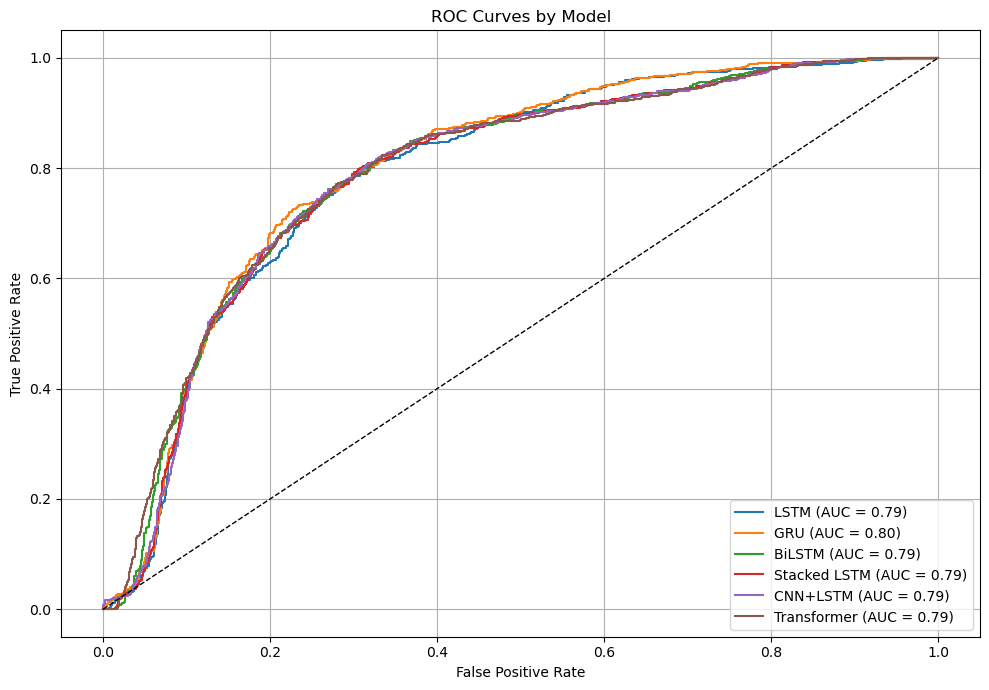

In [77]:
plt.figure(figsize=(10, 7))

models = {
    'LSTM': y_test_probs_lstm,
    'GRU': y_test_probs_gru,
    'BiLSTM': y_test_probs_bi_lstm,
    'Stacked LSTM': y_test_probs_stacked_lstm,
    'CNN+LSTM': y_test_probs_cnn_lstm,
    'Transformer': y_test_probs_transformer,
    # 'Random Forest': y_test_probs_rf,
    # 'XGBoost': y_test_probs_xgb
}

for name, probs in models.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Model')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.savefig('roc_curves.png')
plt.show()


**From these results, our top 3 models are:**
1. XGBoost
2. Transformer
3. CNN + LSTM -> Best time series

______

# ***MACHINE LEARNING PART 2***

## **Forecasting Tool - Using the CNN + LSTM Model**

**Note:** Tried stacking the models chosen above but the results of that were actually lower than the base models, so we scratched that idea. So instead, we will build our foreacasting tool using our CNN + LSTM model. 3 things we will do with analysis: 
- Analyze Important Days in the 21-day Window
- Analyze Feature Importance
- Build a Forecasting Tool (Prediction + Explanation)

**Analyze Important Days in the 21-day Window**

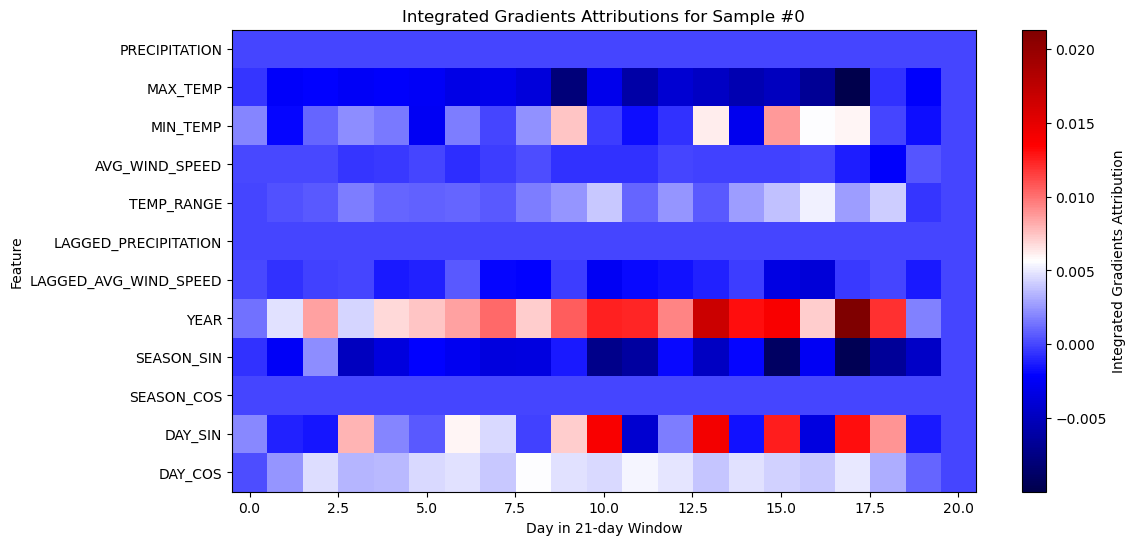

In [12]:
def integrated_gradients(inputs, model, target_class_idx=0, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(inputs)
    
    # Scale inputs and compute gradients
    interpolated_inputs = [baseline + (float(i)/steps)*(inputs - baseline) for i in range(steps+1)]
    interpolated_inputs = tf.convert_to_tensor(np.array(interpolated_inputs), dtype=tf.float32)  # (steps+1, timesteps, features)
    
    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        preds = model(interpolated_inputs)  # shape (steps+1, 1)
        # Select the output for the target class - for binary sigmoid output, just use preds directly
        outputs = preds[:, 0]  
    
    grads = tape.gradient(outputs, interpolated_inputs)  # shape (steps+1, timesteps, features)
    
    avg_grads = tf.reduce_mean(grads[:-1] + grads[1:], axis=0) / 2.0  # trapezoidal approx
    integrated_grads = (inputs - baseline) * avg_grads.numpy()  # element-wise product
    
    return integrated_grads  # shape (timesteps, features)

# Example usage: compute IG for one sample from validation set
sample_idx = 0
sample_input = X_val[sample_idx]

ig_attributions = integrated_gradients(sample_input, model_cnn_lstm)

# Visualize attribution heatmap for 21 days × 12 features
plt.figure(figsize=(12,6))
plt.imshow(ig_attributions.T, cmap='seismic', aspect='auto', interpolation='nearest')
plt.colorbar(label='Integrated Gradients Attribution')
plt.xlabel('Day in 21-day Window')
plt.ylabel('Feature')
plt.yticks(ticks=np.arange(len(feature_cols)), labels=feature_cols)
plt.title('Integrated Gradients Attributions for Sample #{}'.format(sample_idx))
plt.show()

These features are what our CNN+LSTM model looks at and what features and what days most contribute to the model's final predictions. Around the ~15 day marks seems to be the indicator of an event for the model and the features it mostly depends on is the time of year and sometimes the temperature and day.

**Analyze Feature Importance**

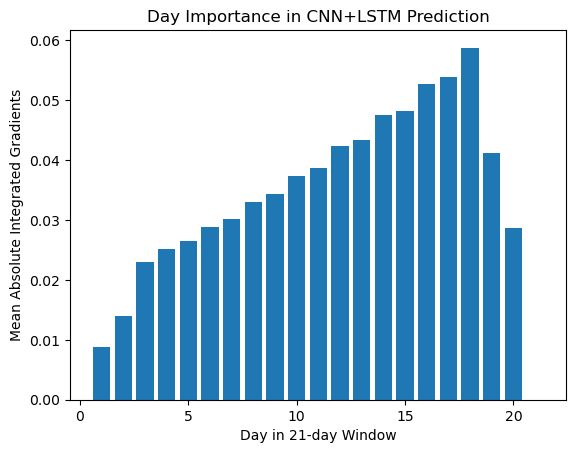

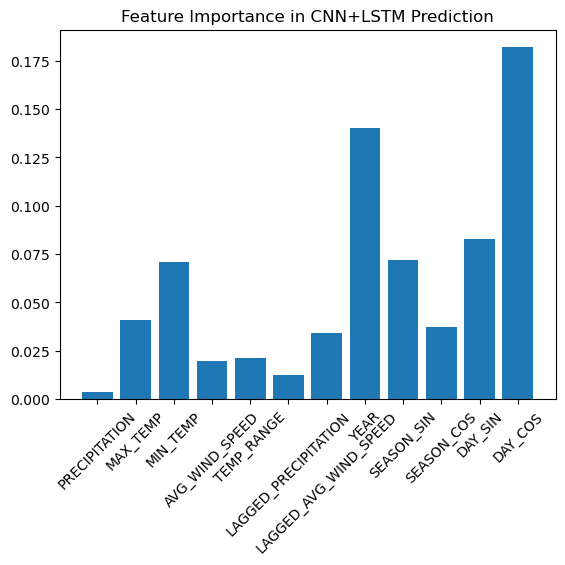

In [13]:
# Compute IG for multiple samples (e.g., 100 from validation)
num_samples_to_explain = 100
all_ig = np.array([integrated_gradients(X_val[i], model_cnn_lstm) for i in range(num_samples_to_explain)])  
# shape (samples, timesteps, features)

# Aggregate day importance: mean absolute attribution per day across features and samples
day_importance = np.mean(np.abs(all_ig).sum(axis=2), axis=0)

plt.bar(range(1, window_size+1), day_importance)
plt.xlabel('Day in 21-day Window')
plt.ylabel('Mean Absolute Integrated Gradients')
plt.title('Day Importance in CNN+LSTM Prediction')
plt.show()

# Aggregate feature importance: mean absolute attribution per feature across days and samples
feature_importance = np.mean(np.abs(all_ig).sum(axis=1), axis=0)

plt.bar(feature_cols, feature_importance)
plt.xticks(rotation=45)
plt.title('Feature Importance in CNN+LSTM Prediction')
plt.show()

The CNN+LSTM model gets a signal of a potential fire around the ~15-20 day mark and the features that help it identify are mostly day (cos), year, and the lagged average wind speed. So essentially what our gradients chart showed.

**Build a Forecasting Tool (Prediction + Explanation)**

**Rough Model - Calculate prediction probability, add label, list features and days contributing to predictions**

In [14]:
def forecasting_tool(input_sequence, model, feature_names, baseline=None, steps=50, threshold=0.45):
    if baseline is None:
        baseline = np.zeros_like(input_sequence)

    # Predict probability
    input_batch = np.expand_dims(input_sequence, axis=0)  # add batch dim
    pred_prob = model.predict(input_batch)[0,0]

    # Calculate Integrated Gradients
    ig_attributions = integrated_gradients(input_sequence, model, baseline=baseline, steps=steps)

    # Aggregate day importance (sum abs over features)
    day_importance = np.sum(np.abs(ig_attributions), axis=1)
    top_days = np.argsort(day_importance)[-3:][::-1]  # top 3 days (most important)

    # Aggregate feature importance (sum abs over days)
    feature_importance = np.sum(np.abs(ig_attributions), axis=0)
    top_features_idx = np.argsort(feature_importance)[-3:][::-1]
    top_features = [feature_names[i] for i in top_features_idx]

    # Binary prediction
    pred_label = int(pred_prob >= threshold)

    return {
        'prediction_prob': pred_prob,
        'prediction_label': pred_label,
        'integrated_gradients': ig_attributions,
        'top_days': top_days,
        'top_features': top_features}

**Rough testing forecast model with a set 21 days (not random yet)**

Shape of last 21 days features: (21, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Fire Probability: 0.140
Prediction Label (threshold=0.45): 0
Top 3 Important Days in window: [16 18 17]
Top 3 Important Features: ['DAY_COS', 'YEAR', 'SEASON_COS']


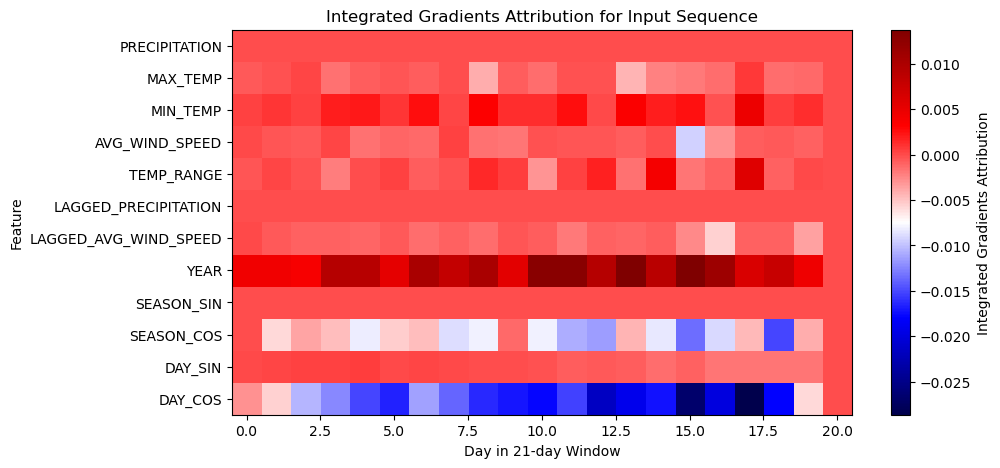

In [15]:
# Get the last 21 days of features
last_21_days_features = df[feature_cols].iloc[-21:].values  # shape (21, n_features)

print("Shape of last 21 days features:", last_21_days_features.shape)

result = forecasting_tool(last_21_days_features, model_cnn_lstm, feature_cols)

print(f"Predicted Fire Probability: {result['prediction_prob']:.3f}")
print(f"Prediction Label (threshold=0.45): {result['prediction_label']}")
print(f"Top 3 Important Days in window: {result['top_days'] + 1}")  # +1 for human-readable days
print(f"Top 3 Important Features: {result['top_features']}")

plt.figure(figsize=(10,5))
plt.imshow(result['integrated_gradients'].T, cmap='seismic', aspect='auto')
plt.colorbar(label='Integrated Gradients Attribution')
plt.xlabel('Day in 21-day Window')
plt.ylabel('Feature')
plt.yticks(ticks=np.arange(len(feature_cols)), labels=feature_cols)
plt.title('Integrated Gradients Attribution for Input Sequence')
plt.show()


**Creating sliding window function of 21 day periods to help test our model on random days**

In [16]:
def sliding_window_forecast(df, feature_cols, model, window_size=21, threshold=0.5):
    # Slide a window over the data, predict fire risk for each day after the first window.
    features = df[feature_cols].values
    total_days = len(features)
    results = []
    # Slide window from day 0 to day total_days - window_size
    for day in range(window_size, total_days):
        window_features = features[day - window_size: day]  # shape (21, n_features)
        window_features = np.expand_dims(window_features, axis=0)  # model expects batch dim
        fire_prob = model.predict(window_features, verbose=0)[0][0]
        fire_pred = int(fire_prob >= threshold)
        results.append({
            'day_index': day,
            'fire_prob': fire_prob,
            'fire_pred': fire_pred
        })
    return pd.DataFrame(results)

**Extremely rough look on what model looks like - takes a while to load (~6 minutes)**

In [205]:
# df_forecast = sliding_window_forecast(df, feature_cols, model_cnn_lstm, window_size=21, threshold=best_thresh_cnn_lstm)
# print(df_forecast.head())

   day_index  fire_prob  fire_pred
0         21   0.106730          0
1         22   0.104867          0
2         23   0.103966          0
3         24   0.103553          0
4         25   0.103363          0


## **FINAL FORECASTING TOOL MODEL**

In [11]:
# Randomly sample N starting points
N = 10  # or however many you want
max_start = len(df) - window_size - 1
random_starts = random.sample(range(max_start), N)

random_preds = []

for start in random_starts:
    seq = df[feature_cols].iloc[start : start + window_size].values
    seq = seq.reshape(1, window_size, -1)

    prob = model_cnn_lstm.predict(seq).flatten()[0]
    pred = int(prob >= best_thresh_cnn_lstm)
    
    true_label = df['FIRE_START_DAY'].iloc[start + window_size]
    is_correct = int(pred == true_label)

    random_preds.append({
        'start_index': start,
        'day_index': start + window_size,
        'fire_prob': prob,
        'fire_pred': pred,
        'true_label': true_label,
        'correct': is_correct
    })

pd.DataFrame(random_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


,start_index,day_index,fire_prob,fire_pred,true_label,correct
0,13468,13489,0.373949,0,0,1
1,14595,14616,0.120597,0,0,1
2,3426,3447,0.605292,1,0,0
3,3858,3879,0.793221,1,1,1
4,3060,3081,0.627209,1,1,1
5,14242,14263,0.019738,0,0,1
6,77,98,0.205272,0,0,1
7,591,612,0.674243,1,0,0
8,11700,11721,0.210941,0,0,1
9,2688,2709,0.553501,1,0,0


## **YAy**